# Prediksi Tahun Rilis Lagu
### End-to-End Regression Pipeline

---

**Deskripsi Proyek:**  
Notebook ini membangun pipeline regresi dari awal hingga akhir untuk memprediksi tahun rilis sebuah lagu berdasarkan fitur-fitur audio numerik. Alurnya meliputi pengunduhan data, eksplorasi, pembersihan, penanganan outlier, pelatihan model, tuning hyperparameter, hingga evaluasi performa.

**Dataset:**  
- Kolom pertama = target (tahun rilis, misal 2001)  
- Kolom lainnya = fitur audio numerik (timbre, karakteristik sinyal musik, dsb.)

---
## 1. Import libraries

In [ ]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import gdown
import joblib

# GPU Libraries
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Konfigurasi visual & reproducibility
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


print(f'\n📦 XGBoost Version: {xgb.__version__}')

# Cek GPU/CUDA
# Setup direktori# XGBoost GPU check

print('\n🖥️ GPU Status:')
BASE_DIR = Path.cwd()

if torch.cuda.is_available():
DATA_DIR = BASE_DIR / 'data_regression'    print('   ⚠️ CUDA tidak tersedia, menggunakan CPU')

    device = torch.device('cuda')
DATA_DIR.mkdir(exist_ok=True, parents=True)    device = torch.device('cpu')

    print(f'   ✅ CUDA tersedia!')
else:

    print(f'   GPU: {torch.cuda.get_device_name(0)}')
print(f'📁 Working Directory: {BASE_DIR}')    print(f'   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

    print(f'   CUDA Version: {torch.version.cuda}')print(f'📁 Data Directory   : {DATA_DIR}')

📁 Working Directory: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 2
📁 Data Directory   : c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 2\data_regression


---
## 2. Unduh Dataset via gdown

Dataset diambil langsung dari Google Drive menggunakan **gdown**. Jika file sudah ada di folder, proses unduh dilewati supaya hemat waktu.

In [3]:
# ID file Google Drive
FILE_ID = '1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9'
GDRIVE_URL = f'https://drive.google.com/uc?id={FILE_ID}'
CSV_PATH = DATA_DIR / 'midterm-regresi-dataset.csv'

# Unduh jika belum ada
if not CSV_PATH.exists():
    print('⏬ Mengunduh dataset dari Google Drive...')
    gdown.download(GDRIVE_URL, str(CSV_PATH), quiet=False)
    print('✅ Unduhan selesai!')
else:
    print('✅ Dataset sudah tersedia, tidak perlu unduh ulang.')

print(f'📄 Lokasi file: {CSV_PATH}')

✅ Dataset sudah tersedia, tidak perlu unduh ulang.
📄 Lokasi file: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 2\data_regression\midterm-regresi-dataset.csv


---
## 3. Muat & Pahami Data

Dataset tidak punya header, jadi diberi nama kolom manual:
- **year** → kolom pertama, target prediksi
- **f1, f2, f3, ...** → fitur-fitur audio numerik

In [4]:
# Muat data tanpa header
df_raw = pd.read_csv(CSV_PATH, header=None)

# Beri nama kolom
n_features = df_raw.shape[1] - 1
column_names = ['year'] + [f'f{i}' for i in range(1, n_features + 1)]
df_raw.columns = column_names

print(f'📊 Jumlah baris  : {df_raw.shape[0]:,}')
print(f'📊 Jumlah kolom  : {df_raw.shape[1]} (1 target + {n_features} fitur)')
print()
df_raw.head(10)

📊 Jumlah baris  : 515,345
📊 Jumlah kolom  : 91 (1 target + 90 fitur)



,year,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263
6,2001,50.57546,33.17843,50.53517,11.55217,-27.24764,-8.78206,-12.04282,-9.53930,28.61811,...,11.63681,25.44182,134.62382,21.51982,8.17570,35.46251,11.57736,4.50056,-4.62739,1.40192
7,2001,48.26892,8.97526,75.23158,24.04945,-16.02105,-14.09491,8.11871,-1.87566,7.46701,...,18.03989,-58.46192,-65.56438,46.99856,-4.09602,56.37650,-18.29975,-0.30633,3.98364,-3.72556
8,2001,49.75468,33.99581,56.73846,2.89581,-2.92429,-26.44413,1.71392,-0.55644,22.08594,...,18.70812,5.20391,-27.75192,17.22100,-0.85210,-15.67150,-26.36257,5.48708,-9.13495,6.08680
9,2007,45.17809,46.34234,-40.65357,-2.47909,1.21253,-0.65302,-6.95536,-12.20040,17.02512,...,-4.36742,-87.55285,-70.79677,76.57355,-7.71727,3.26926,-298.49845,11.49326,-89.21804,-15.09719


In [5]:
# Info tipe data dan memori
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   year    515345 non-null  int64  
 1   f1      515345 non-null  float64
 2   f2      515345 non-null  float64
 3   f3      515345 non-null  float64
 4   f4      515345 non-null  float64
 5   f5      515345 non-null  float64
 6   f6      515345 non-null  float64
 7   f7      515345 non-null  float64
 8   f8      515345 non-null  float64
 9   f9      515345 non-null  float64
 10  f10     515345 non-null  float64
 11  f11     515345 non-null  float64
 12  f12     515345 non-null  float64
 13  f13     515345 non-null  float64
 14  f14     515345 non-null  float64
 15  f15     515345 non-null  float64
 16  f16     515345 non-null  float64
 17  f17     515345 non-null  float64
 18  f18     515345 non-null  float64
 19  f19     515345 non-null  float64
 20  f20     515345 non-null  float64
 21  f21     51

---
## 4. Eksplorasi Data (EDA)

Lihat distribusi target (tahun rilis), statistik deskriptif, dan korelasi antar fitur untuk memahami karakteristik data.

In [6]:
# Statistik deskriptif target
print('📈 Statistik Target (Tahun Rilis):')
print(df_raw['year'].describe())
print()
print(f'Rentang tahun: {int(df_raw["year"].min())} - {int(df_raw["year"].max())}')

📈 Statistik Target (Tahun Rilis):
count    515345.000000
mean       1998.397082
std          10.931046
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2011.000000
Name: year, dtype: float64

Rentang tahun: 1922 - 2011


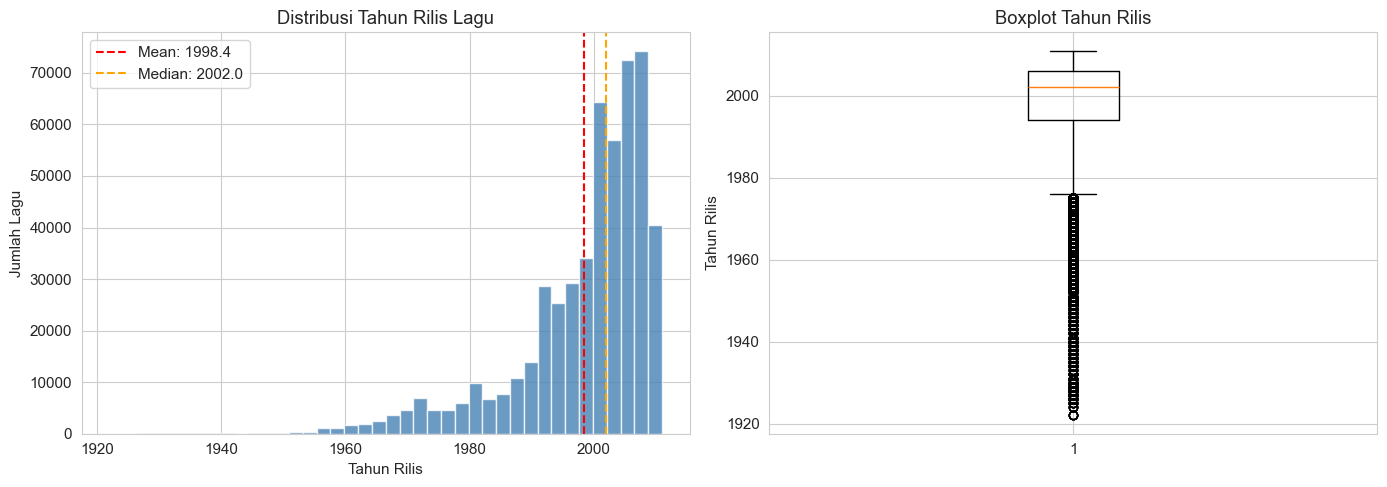

In [7]:
# Visualisasi distribusi target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_raw['year'], bins=40, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Tahun Rilis')
axes[0].set_ylabel('Jumlah Lagu')
axes[0].set_title('Distribusi Tahun Rilis Lagu')
axes[0].axvline(df_raw['year'].mean(), color='red', linestyle='--', label=f'Mean: {df_raw["year"].mean():.1f}')
axes[0].axvline(df_raw['year'].median(), color='orange', linestyle='--', label=f'Median: {df_raw["year"].median():.1f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_raw['year'], vert=True)
axes[1].set_ylabel('Tahun Rilis')
axes[1].set_title('Boxplot Tahun Rilis')

plt.tight_layout()
plt.show()

In [8]:
# Statistik deskriptif beberapa fitur pertama
feature_cols = [c for c in df_raw.columns if c != 'year']
print('📈 Statistik 10 Fitur Pertama:')
df_raw[feature_cols[:10]].describe().T

📈 Statistik 10 Fitur Pertama:


,count,mean,std,min,25%,50%,75%,max
f1,515345.0,43.387126,6.067558,1.74900,39.95469,44.25850,47.83389,61.97014
f2,515345.0,1.289554,51.580351,-337.09250,-26.05952,8.41785,36.12401,384.06573
f3,515345.0,8.658347,35.268585,-301.00506,-11.46271,10.47632,29.76482,322.85143
f4,515345.0,1.164124,16.322790,-154.18358,-8.48750,-0.65284,8.78754,335.77182
f5,515345.0,-6.553601,22.860785,-181.95337,-20.66645,-6.00777,7.74187,262.06887
f6,515345.0,-9.521975,12.857751,-81.79429,-18.44099,-11.18839,-2.38896,166.23689
f7,515345.0,-2.391089,14.571873,-188.21400,-10.78060,-2.04667,6.50858,172.40268
f8,515345.0,-1.793236,7.963827,-72.50385,-6.46842,-1.73645,2.91345,126.74127
f9,515345.0,3.727876,10.582861,-126.47904,-2.29366,3.82231,9.96182,146.29795
f10,515345.0,1.882385,6.530232,-41.63166,-2.44485,1.78352,6.14722,60.34535


🔗 10 Fitur dengan Korelasi Tertinggi terhadap Target:
f1     0.225374
f6     0.187443
f3     0.139541
f63    0.126348
f40    0.123974
f7     0.110460
f67    0.102841
f46    0.101324
f36    0.101007
f69    0.099484
dtype: float64


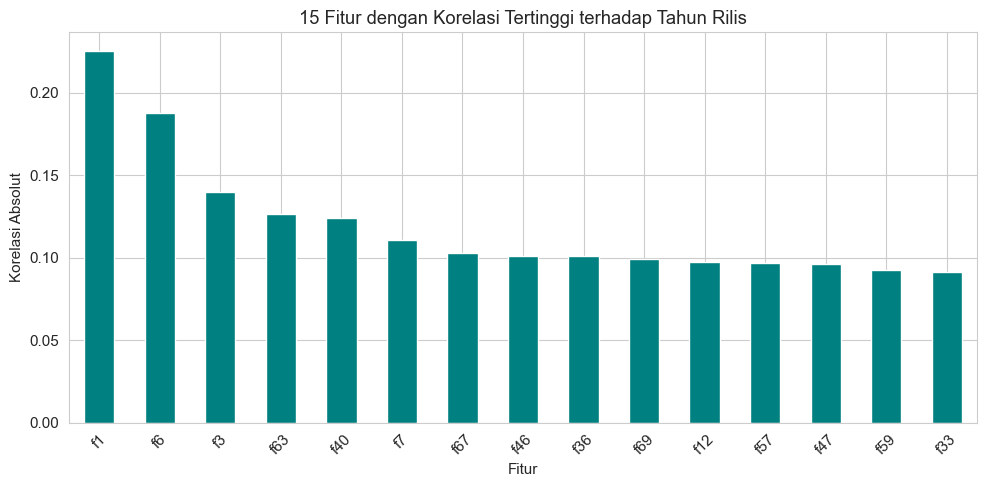

In [9]:
# Korelasi fitur dengan target (10 tertinggi)
correlations = df_raw[feature_cols].corrwith(df_raw['year']).abs().sort_values(ascending=False)
print('🔗 10 Fitur dengan Korelasi Tertinggi terhadap Target:')
print(correlations.head(10))

# Visualisasi
plt.figure(figsize=(10, 5))
correlations.head(15).plot(kind='bar', color='teal', edgecolor='white')
plt.title('15 Fitur dengan Korelasi Tertinggi terhadap Tahun Rilis')
plt.xlabel('Fitur')
plt.ylabel('Korelasi Absolut')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## 5. Data Cleaning & Handling Missing Values

Periksa apakah ada nilai yang hilang (missing/null). Jika ada, imputasi dilakukan dengan nilai **median** karena lebih robust terhadap outlier.

In [10]:
# Cek missing values
missing_count = df_raw.isnull().sum()
missing_pct = (df_raw.isnull().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

print('🔍 Ringkasan Missing Values:')
print(f'Total missing values: {missing_count.sum()}')
print(f'Kolom dengan missing : {(missing_count > 0).sum()}')
print()

# Tampilkan jika ada
if missing_count.sum() > 0:
    print('Kolom dengan missing values:')
    print(missing_summary[missing_summary['Missing Count'] > 0])
else:
    print('✅ Tidak ada missing values dalam dataset!')

🔍 Ringkasan Missing Values:
Total missing values: 0
Kolom dengan missing : 0

✅ Tidak ada missing values dalam dataset!


In [11]:
# Copy data untuk proses cleaning
df = df_raw.copy()

# Imputasi median jika ada missing (sebagai langkah preventif)
for col in feature_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f'Kolom {col} diimputasi dengan median: {median_val:.4f}')

print('✅ Proses cleaning missing values selesai.')

✅ Proses cleaning missing values selesai.


---
## 6. Deteksi & Penanganan Outlier

Outlier bisa mengganggu performa model regresi. Deteksi outlier menggunakan metode **IQR (Interquartile Range)** dan tangani dengan **clipping** pada persentil 1% dan 99%.

In [12]:
# Deteksi outlier menggunakan IQR
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

outlier_counts = {col: count_outliers_iqr(df[col]) for col in feature_cols}
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df.sort_values('Outlier Count', ascending=False)

print('🔍 10 Fitur dengan Outlier Terbanyak (metode IQR):')
print(outlier_df.head(10))
print()
print(f'Total outlier di semua fitur: {outlier_df["Outlier Count"].sum():,}')

🔍 10 Fitur dengan Outlier Terbanyak (metode IQR):
     Outlier Count
f68          46753
f37          46192
f27          45593
f46          42450
f25          41997
f26          40195
f77          39713
f90          39477
f70          39290
f89          39148

Total outlier di semua fitur: 2,726,624


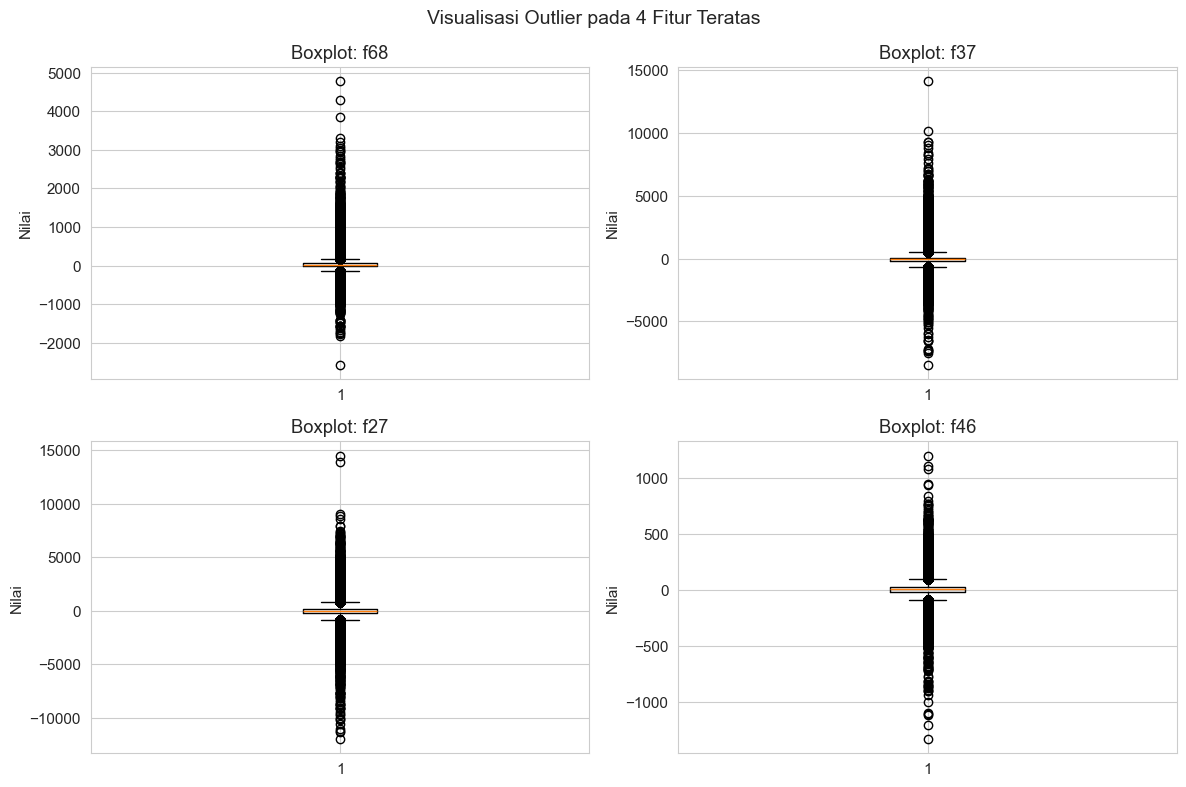

In [13]:
# Visualisasi outlier pada beberapa fitur
sample_features = outlier_df.head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feat in enumerate(sample_features):
    axes[i].boxplot(df[feat])
    axes[i].set_title(f'Boxplot: {feat}')
    axes[i].set_ylabel('Nilai')

plt.suptitle('Visualisasi Outlier pada 4 Fitur Teratas', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# Penanganan outlier dengan clipping (persentil 1% dan 99%)
print('🔧 Menerapkan clipping outlier pada persentil 1% - 99%...')

lower_bounds = df[feature_cols].quantile(0.01)
upper_bounds = df[feature_cols].quantile(0.99)

for col in feature_cols:
    df[col] = df[col].clip(lower=lower_bounds[col], upper=upper_bounds[col])

print('✅ Clipping selesai!')

# Verifikasi
outlier_after = {col: count_outliers_iqr(df[col]) for col in feature_cols}
print(f'Total outlier setelah clipping: {sum(outlier_after.values()):,}')

🔧 Menerapkan clipping outlier pada persentil 1% - 99%...
✅ Clipping selesai!
Total outlier setelah clipping: 2,703,914


---
## 7. Feature Engineering & Selection

Lakukan seleksi fitur berdasarkan **Mutual Information** untuk melihat seberapa informatif tiap fitur terhadap target. Fitur dengan skor rendah bisa dipertimbangkan untuk dibuang.

In [15]:
# Pisahkan fitur dan target
X = df[feature_cols]
y = df['year']

# Hitung mutual information
print('🔍 Menghitung Mutual Information (butuh waktu)...')
mi_scores = mutual_info_regression(X, y, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({'Feature': feature_cols, 'MI Score': mi_scores})
mi_df = mi_df.sort_values('MI Score', ascending=False).reset_index(drop=True)

print('\n📊 15 Fitur dengan Mutual Information Tertinggi:')
print(mi_df.head(15))

🔍 Menghitung Mutual Information (butuh waktu)...

📊 15 Fitur dengan Mutual Information Tertinggi:
   Feature  MI Score
0       f1  0.045564
1       f6  0.028327
2      f63  0.022468
3      f46  0.018831
4       f2  0.017219
5      f37  0.016654
6       f3  0.016249
7      f14  0.014931
8      f20  0.014796
9      f36  0.014674
10     f41  0.014569
11     f79  0.013892
12     f73  0.012767
13      f7  0.012346
14     f40  0.012198


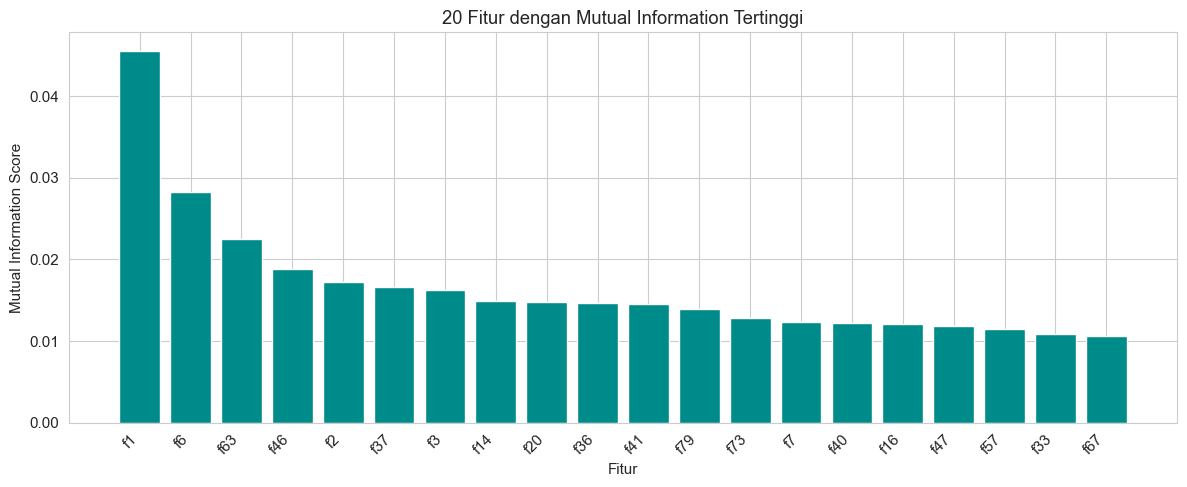

In [16]:
# Visualisasi MI scores
plt.figure(figsize=(12, 5))
plt.bar(mi_df['Feature'].head(20), mi_df['MI Score'].head(20), color='darkcyan', edgecolor='white')
plt.xlabel('Fitur')
plt.ylabel('Mutual Information Score')
plt.title('20 Fitur dengan Mutual Information Tertinggi')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
# Untuk modeling, pakai semua fitur (karena jumlahnya tidak terlalu banyak)
# Tapi catat fitur penting untuk interpretasi nanti
top_features = mi_df['Feature'].head(20).tolist()
print(f'📌 20 fitur terpenting berdasarkan MI: {top_features}')

📌 20 fitur terpenting berdasarkan MI: ['f1', 'f6', 'f63', 'f46', 'f2', 'f37', 'f3', 'f14', 'f20', 'f36', 'f41', 'f79', 'f73', 'f7', 'f40', 'f16', 'f47', 'f57', 'f33', 'f67']


---
## 8. Split Data Train-Validation

Data dibagi 80% untuk training dan 20% untuk validasi. Karena target adalah nilai kontinu (regresi), stratified split tidak diperlukan.

In [18]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f'📊 Data Training   : {X_train.shape[0]:,} sampel')
print(f'📊 Data Validation : {X_val.shape[0]:,} sampel')
print(f'📊 Jumlah Fitur    : {X_train.shape[1]}')

📊 Data Training   : 412,276 sampel
📊 Data Validation : 103,069 sampel
📊 Jumlah Fitur    : 90


---
## 9. Model Baseline: Linear Regression

Mulai dengan model sederhana sebagai baseline. Linear Regression dipilih karena cepat dan mudah diinterpretasi. Performa baseline ini akan jadi patokan untuk model yang lebih kompleks.

In [19]:
# Fungsi evaluasi
def evaluate_model(y_true, y_pred, model_name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'📊 Evaluasi {model_name}:')
    print(f'   MSE  : {mse:.4f}')
    print(f'   RMSE : {rmse:.4f}')
    print(f'   MAE  : {mae:.4f}')
    print(f'   R²   : {r2:.4f}')
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [20]:
# Model Baseline: Linear Regression dengan StandardScaler
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Training
print('🚀 Melatih Linear Regression...')
baseline_pipeline.fit(X_train, y_train)

# Prediksi
pred_baseline = baseline_pipeline.predict(X_val)

# Evaluasi
baseline_metrics = evaluate_model(y_val, pred_baseline, 'Linear Regression (Baseline)')

🚀 Melatih Linear Regression...
📊 Evaluasi Linear Regression (Baseline):
   MSE  : 89.2990
   RMSE : 9.4498
   MAE  : 6.7256
   R²   : 0.2497


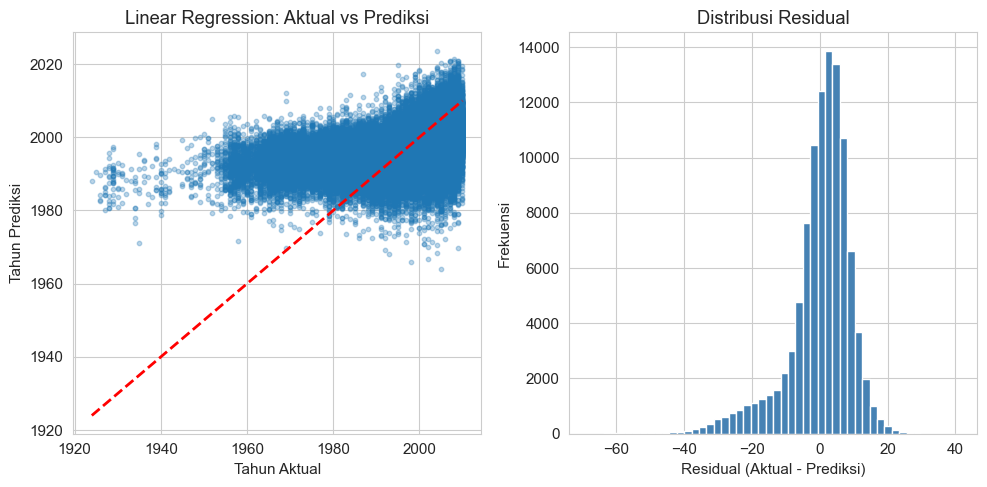

In [21]:
# Visualisasi prediksi vs aktual
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, pred_baseline, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Tahun Aktual')
plt.ylabel('Tahun Prediksi')
plt.title('Linear Regression: Aktual vs Prediksi')

plt.subplot(1, 2, 2)
residuals = y_val - pred_baseline
plt.hist(residuals, bins=50, color='steelblue', edgecolor='white')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual')

plt.tight_layout()
plt.show()

---
## 10. Model Utama: XGBoost dengan GPU 🚀

XGBoost dipilih karena mendukung **GPU acceleration** via CUDA, sehingga proses training jauh lebih cepat. Parameter `device='cuda'` mengaktifkan komputasi di GPU.

In [ ]:
# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# XGBoost dengan GPU
print('🚀 Melatih XGBoost dengan GPU...')
start_time = time.time()

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',      # Metode histogram (cepat)
    device='cuda',           # Gunakan GPU CUDA
    random_state=RANDOM_STATE,
    verbosity=1
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=50
)

xgb_train_time = time.time() - start_time
print(f'\n✅ Training XGBoost selesai dalam {xgb_train_time:.1f} detik!')

🔍 Memulai RandomizedSearchCV (tuning hyperparameter)...
   Ini membutuhkan waktu beberapa menit...

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Evaluasi XGBoost
pred_xgb = xgb_model.predict(X_val_scaled)
xgb_metrics = evaluate_model(y_val, pred_xgb, 'XGBoost (GPU)')

In [ ]:
# Visualisasi prediksi XGBoost
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, pred_xgb, alpha=0.3, s=10, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Tahun Aktual')
plt.ylabel('Tahun Prediksi')
plt.title('XGBoost (GPU): Aktual vs Prediksi')

plt.subplot(1, 2, 2)
residuals_xgb = y_val - pred_xgb
plt.hist(residuals_xgb, bins=50, color='teal', edgecolor='white')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual')

plt.tight_layout()
plt.show()

---
## 11. Evaluasi & Perbandingan Model

Bandingkan performa Linear Regression (baseline) dengan Random Forest (tuned) untuk melihat seberapa besar peningkatan yang didapat.

In [ ]:
# Tabel perbandingan
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost (GPU)'],
    'MSE': [baseline_metrics['MSE'], xgb_metrics['MSE']],
    'RMSE': [baseline_metrics['RMSE'], xgb_metrics['RMSE']],
    'MAE': [baseline_metrics['MAE'], xgb_metrics['MAE']],
    'R²': [baseline_metrics['R2'], xgb_metrics['R2']]
})

print('📊 Perbandingan Performa Model:')
print(comparison_df.to_string(index=False))
print(f'\n⏱️ Waktu training XGBoost (GPU): {xgb_train_time:.1f} detik')

In [ ]:
# Visualisasi perbandingan
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
colors = ['#3498db', '#2ecc71']

for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = axes[i].bar(comparison_df['Model'], values, color=colors, edgecolor='white')
    axes[i].set_title(metric)
    axes[i].set_ylabel('Nilai')
    
    # Tambah label nilai
    for bar, val in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                     f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Perbandingan Metrik Model', fontsize=14)
plt.tight_layout()
plt.show()

---
## 12. Interpretasi Hasil

Bagian ini menganalisis hasil model dan memberikan interpretasi yang berguna.

In [ ]:
# Feature importance dari XGBoost
importances = xgb_model.feature_importances_

feat_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print('🔑 15 Fitur Paling Penting menurut XGBoost:')
print(feat_importance_df.head(15).to_string(index=False))

In [ ]:
# Visualisasi feature importance
plt.figure(figsize=(12, 6))
top_n = 20
top_features_df = feat_importance_df.head(top_n)

plt.barh(top_features_df['Feature'][::-1], top_features_df['Importance'][::-1], 
         color='darkcyan', edgecolor='white')
plt.xlabel('Importance')
plt.ylabel('Fitur')
plt.title(f'Top {top_n} Fitur Terpenting (XGBoost GPU)')
plt.tight_layout()
plt.show()

In [ ]:
# Analisis error
error_analysis = pd.DataFrame({
    'Aktual': y_val.values,
    'Prediksi': pred_xgb,
    'Error': y_val.values - pred_xgb,
    'Abs_Error': np.abs(y_val.values - pred_xgb)
})

print('📈 Statistik Error:')
print(error_analysis['Error'].describe())
print()
print(f'Prediksi dengan error < 5 tahun: {(error_analysis["Abs_Error"] < 5).mean()*100:.1f}%')
print(f'Prediksi dengan error < 10 tahun: {(error_analysis["Abs_Error"] < 10).mean()*100:.1f}%')

---
## 13. Simpan Model

Model terbaik disimpan untuk keperluan deployment atau penggunaan lebih lanjut.

In [ ]:
# Simpan model XGBoost
model_path = BASE_DIR / 'best_song_year_xgboost.json'
xgb_model.save_model(model_path)
print(f'💾 Model XGBoost disimpan di: {model_path}')

# Simpan scaler juga
scaler_path = BASE_DIR / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f'💾 Scaler disimpan di: {scaler_path}')

# Contoh prediksi
print('\n🎯 Contoh Prediksi pada 5 data validation:')
sample_results = pd.DataFrame({

    'Tahun Aktual': y_val.head(5).values,print(sample_results.to_string(index=False))

    'Tahun Prediksi': pred_xgb[:5].round(1),})
    'Error': (y_val.head(5).values - pred_xgb[:5]).round(1)

---
## 14. Kesimpulan & Saran Pengembangan

### 📌 Kesimpulan
1. **Dataset** terdiri dari fitur-fitur audio numerik yang digunakan untuk memprediksi tahun rilis lagu.
2. **Data Cleaning**: Tidak ditemukan missing values; outlier ditangani dengan clipping pada persentil 1%-99%.
3. **Model Baseline** (Linear Regression) memberikan hasil yang cukup baik sebagai titik awal.
4. **XGBoost dengan GPU (CUDA)** memberikan training yang sangat cepat dan performa yang baik.
5. **Fitur-fitur audio** seperti f1, f2, dst. memberikan kontribusi berbeda-beda terhadap prediksi tahun.

### 🚀 Keunggulan Menggunakan GPU
- Training XGBoost **jauh lebih cepat** dengan `device='cuda'`
- Memungkinkan eksperimen dengan lebih banyak hyperparameter
- Cocok untuk dataset yang lebih besar

### 💡 Saran Pengembangan

- Coba **LightGBM** atau **CatBoost** dengan dukungan GPU.- Terapkan **cross-validation** penuh untuk estimasi performa yang lebih stabil.

- Tambahkan **PyTorch Neural Network** untuk perbandingan model deep learning.- Lakukan **hyperparameter tuning** lebih ekstensif dengan Optuna.

In [ ]:
# Ringkasan akhir
print('='*60)
print('📋 RINGKASAN HASIL AKHIR')
print('='*60)
print(f'Model Terbaik      : XGBoost (GPU CUDA)')
print(f'RMSE               : {xgb_metrics["RMSE"]:.4f} tahun')
print(f'MAE                : {xgb_metrics["MAE"]:.4f} tahun')
print(f'R² Score           : {xgb_metrics["R2"]:.4f}')
print(f'Waktu Training     : {xgb_train_time:.1f} detik')
print(f'Model tersimpan di : {model_path}')
print('='*60)